In [42]:
import jcopdl

In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

- cek apakah dilakukan normalisasi pada model yang kita akan gunakan


- Referensi
https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

In [45]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [46]:
bs = 16
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale = (0.9, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(240),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("oilspill_dataset_fix/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=1)

test_set = datasets.ImageFolder("oilspill_dataset_fix/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [47]:
label2cat = train_set.classes
label2cat

['nospill', 'oilspill']

# Arsitektur & Config

### Contoh cara pakai pre trained model

In [48]:
from torchvision.models import mobilenet_v2

In [49]:
mnet = mobilenet_v2(pretrained = True) #akan download mobilenet weightnya dulu

#Cara untuk ngefreeze
for param in mnet.parameters():
    param.requires_grad = False

- Load a pretrained-model
- freeze the feature extractor
- modify the classifier to our data, leave it unfreezed
- train only on the classifier

In [50]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [51]:
# mengubah classifer out nya sesuai dengan data yang kita punya
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.LogSoftmax()
)

In [52]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.LogSoftmax()
        )
        
    def forward(self,x):
        return self.mnet(x)
    
    def freeze(self):
        for param in mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in mnet.parameters():
            param.requires_grad = True

In [53]:
# Parameter apa saja yang ingin disimpan, biasanya crop size 224 x 224
config = set_config({
    "output_size" : len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Phase 1: adaptatin (lr standar + patience kecil)

In [54]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience = 5, outdir="model")

- loop function yang digunakan yang standar karena di multilabel tidak dapat dihitung accuracynya

In [55]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.5749 | Test_cost  = 1.0582 | Train_score = 0.7716 | Test_score = 0.7143 |




Epoch     2
Train_cost  = 0.3281 | Test_cost  = 0.6806 | Train_score = 0.8832 | Test_score = 0.7959 |




Epoch     3
Train_cost  = 0.2301 | Test_cost  = 0.5182 | Train_score = 0.9086 | Test_score = 0.8367 |




Epoch     4
Train_cost  = 0.3061 | Test_cost  = 0.4667 | Train_score = 0.8731 | Test_score = 0.8571 |




Epoch     5
Train_cost  = 0.2983 | Test_cost  = 1.3181 | Train_score = 0.8883 | Test_score = 0.7959 |
==> EarlyStop patience =  1 | Best test_score: 0.8571




Epoch     6
Train_cost  = 0.1683 | Test_cost  = 0.6127 | Train_score = 0.9391 | Test_score = 0.7551 |
==> EarlyStop patience =  2 | Best test_score: 0.8571




Epoch     7
Train_cost  = 0.1290 | Test_cost  = 0.6559 | Train_score = 0.9340 | Test_score = 0.8163 |
==> EarlyStop patience =  3 | Best test_score: 0.8571




Epoch     8
Train_cost  = 0.1214 | Test_cost  = 0.6347 | Train_score = 0.9492 | Test_score = 0.7959 |
==> EarlyStop patience =  4 | Best test_score: 0.8571




Epoch     9
Train_cost  = 0.2456 | Test_cost  = 1.0469 | Train_score = 0.9594 | Test_score = 0.7551 |
==> EarlyStop patience =  5 | Best test_score: 0.8571
==> Execute Early Stopping at epoch: 9 | Best test_score: 0.8571
==> Best model is saved at model


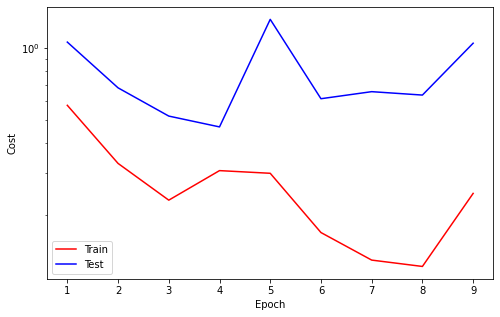

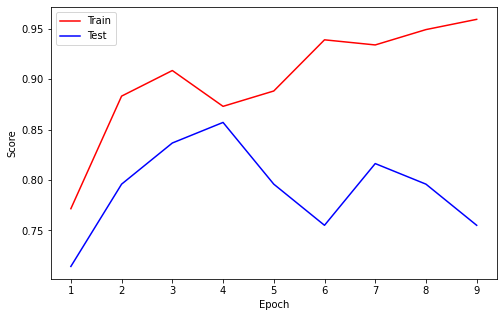

In [56]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [63]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [64]:
with torch.no_grad():
    model.eval()
    output = model (feature)
    preds = output
preds

tensor([[-2.7988e+00, -6.2815e-02],
        [-3.8223e+00, -2.2119e-02],
        [-6.6605e+00, -1.2814e-03],
        [-1.4326e-03, -6.5490e+00],
        [-9.9827e-03, -4.6119e+00],
        [-1.2302e-04, -9.0037e+00],
        [-2.3660e-04, -8.3492e+00],
        [-1.2862e-04, -8.9589e+00],
        [-1.8094e-04, -8.6176e+00],
        [-1.3827e-04, -8.8863e+00],
        [-1.2500e-03, -6.6852e+00],
        [-9.7151e-05, -9.2387e+00],
        [-3.9834e+00, -1.8799e-02],
        [-9.1734e+00, -1.0371e-04],
        [-9.1659e+00, -1.0454e-04],
        [-1.0236e+01, -3.5881e-05]])

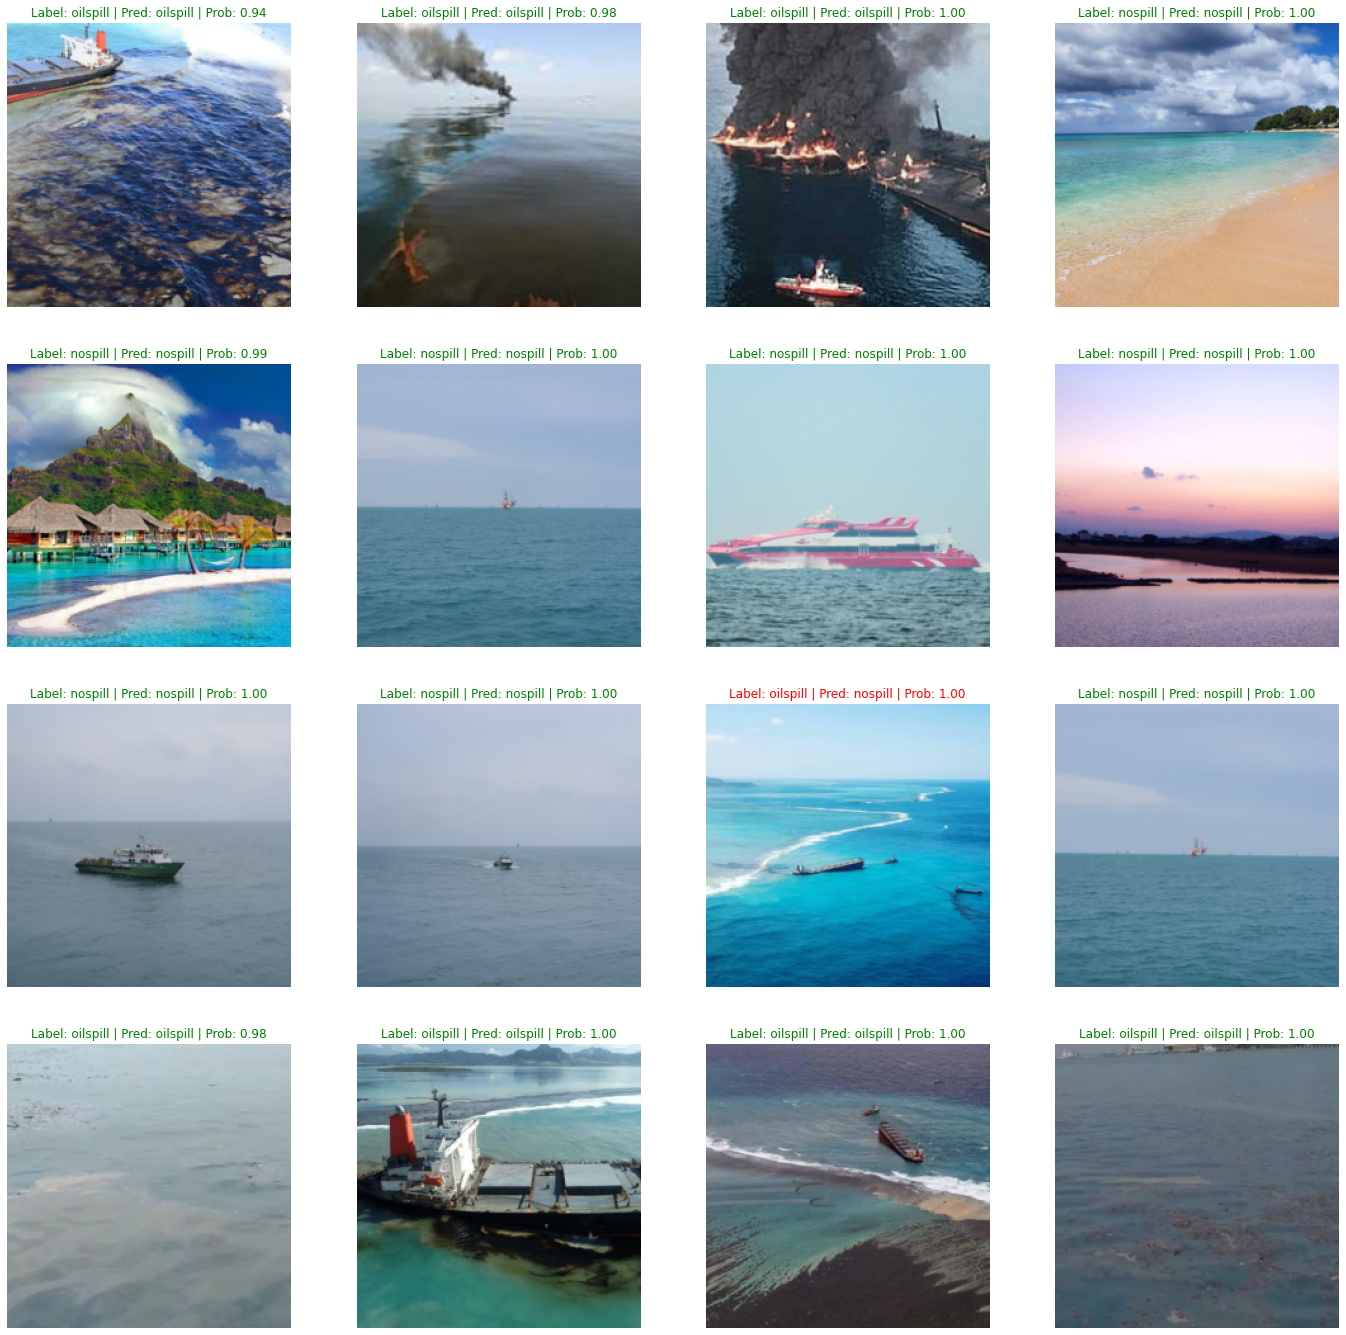

In [65]:
fig, axes = plt.subplots(4,4, figsize = (24,24))

for img, label, pred, ax in zip (feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color": 'r'} if label != pred.argmax(0) else {"color":'g'}
    label, pred, prob = label2cat [label.item()], label2cat[pred.argmax(0).item()], "{:.2f}".format(max(np.exp(pred)).item())
    ax.set_title(f"Label: {label} | Pred: {pred} | Prob: {prob}", fontdict= font)
    ax.axis("off")

In [67]:
fig.savefig("oilspill.jpg")

In [68]:
from PIL import Image
def image_loader(image_name):
    image = Image.open(image_name)
    image = test_transform(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

In [83]:
images = image_loader("new_image/test.jpg")
images.shape

torch.Size([1, 3, 224, 224])

In [84]:
with torch.no_grad():
    model.eval()
    output = model (images)
    print(f"there is %s with probability %s" %(label2cat[output.argmax(1).item()], "{:.2f}".format(max(np.exp(output)[0]))))

there is oilspill with probability 0.99


# Phase 2: fine-tuning (LR dikecilin, patience ditambah)
- biasanya score akan jump ketika dilakukan fine tuning

In [ ]:
model.unfreeze()
optimizer = optim.AdamW (model.parameters(), lr= 1e-5)

#mengatur ulang early stop patience
callback.reset_early_stop()
callback.early_stop_patience = 5

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [ ]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Predict

In [38]:
feature, target = next (iter(testloader))
feature, target = feature.to(device), target.to(device)

In [39]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5 ).to(torch.float32)
preds

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

# Sanity check

In [40]:
def convert_to_label(x):
    return [label for pred, label in zip (x, label2cat) if pred == 1]
def inverse_norm(img):
    img[0,:,:] = img[0,:,:] * 0.229 + 0.485
    img[1,:,:] = img[1,:,:] * 0.224 + 0.456
    img[2,:,:] = img[2,:,:] * 0.225 + 0.406
    return img

TypeError: iteration over a 0-d tensor

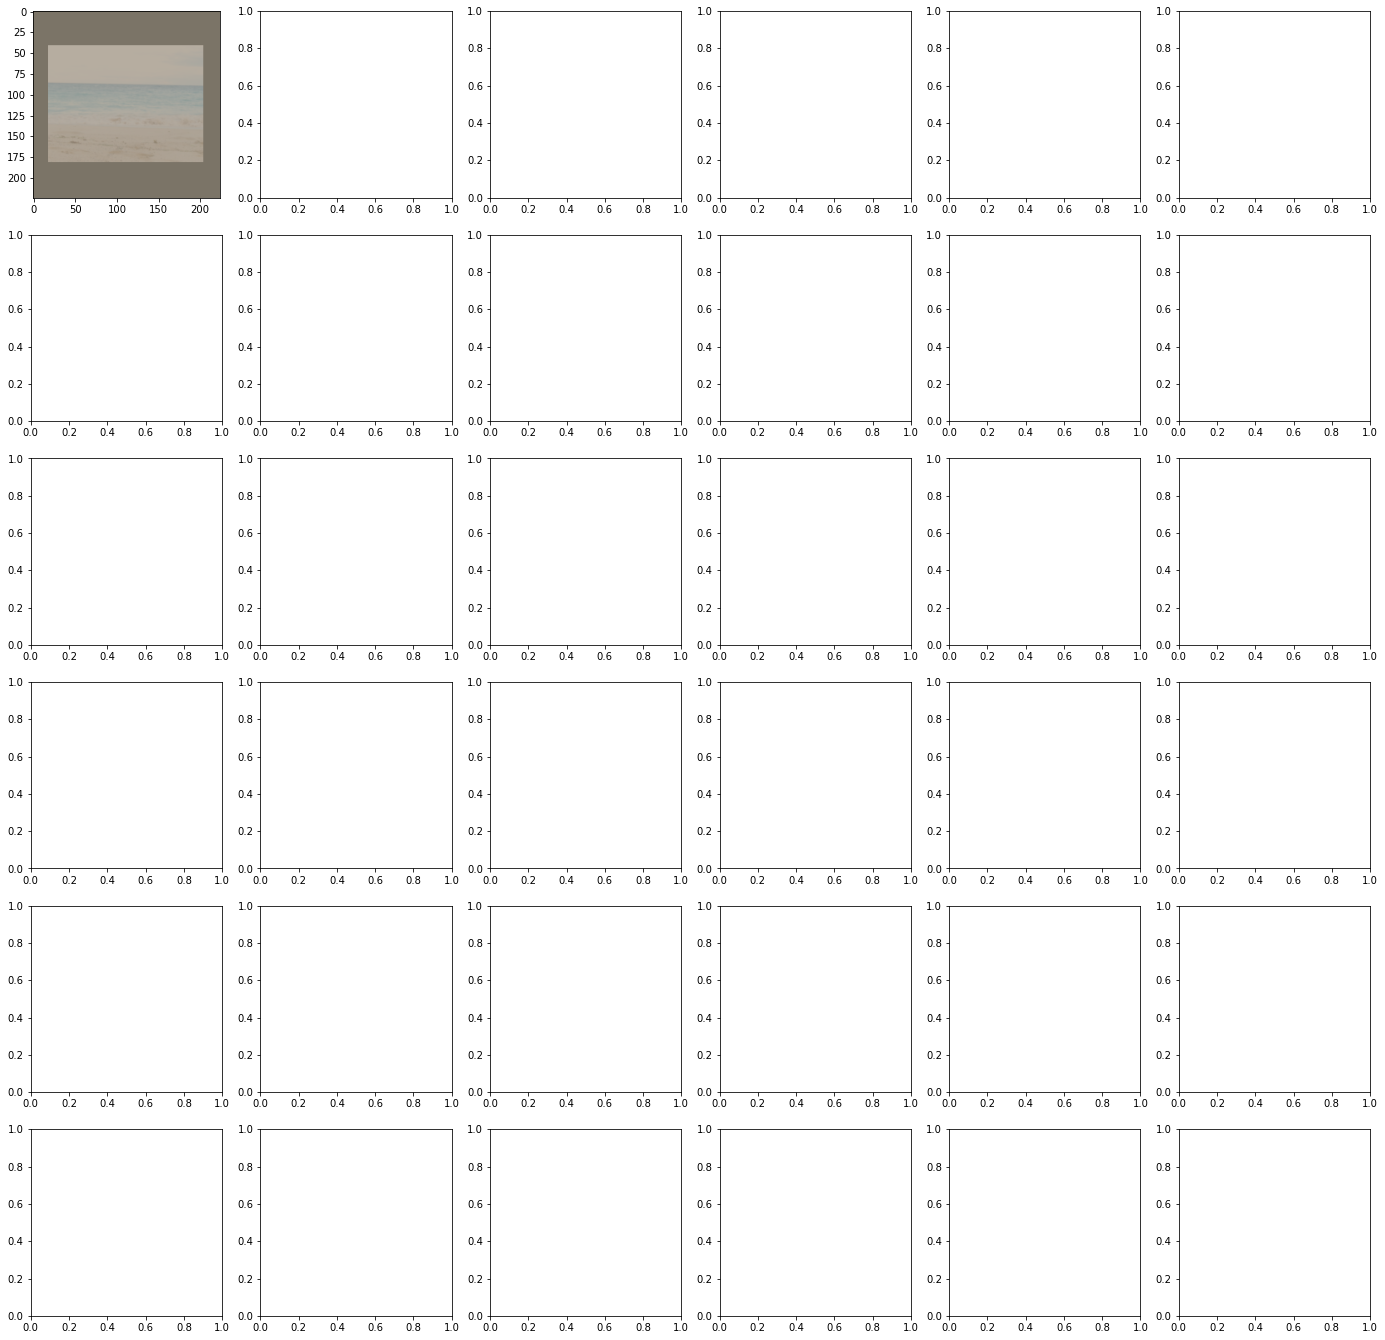

In [41]:
fig, axes = plt.subplots(6,6, figsize = (24,24))

for img, label, pred, ax in zip (feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
    font = {"color": 'r'} if (pred != label).any() else {"color":'g'}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict= font)
    ax.axis("off")